# GAN for Pythia hadronization

In [3]:
import random as rnd
import numpy as np
import particle as pypart

In [28]:
partstrange = {3: 1, 130: 0, 310: 0, 311: 1, 313: 1, 315: 1, 321: 1, 323: 1, 325: 1, 
               331: 2, 333: 2, 335: 2, 
              3101: 1, 3112: 1, 3114: 1, 3122: 1, 3212: 1, 3214: 1, 3222: 1, 3224: 1, 
              3303: 2, 3312: 2, 3314: 2, 3322: 2, 3324: 2, 3334: 3}
beamremnants = {1103: {'name':"dd_1", 'charge': -2, 'mass': 0.77133},
                2101: {'name':"ud_0", 'charge': 1, 'mass': 0.57933},
                2103: {'name':"ud_1", 'charge': 1, 'mass': 0.77133},
                2203: {'name':"uu_1", 'charge': 4, 'mass': 0.77133},
                3101: {'name':"sd_0", 'charge': -2, 'mass': 0.80473},
                3103: {'name':"sd_1", 'charge': -2, 'mass': 0.92953},
                3201: {'name':"su_0", 'charge': 1, 'mass': 0.80473},
                3203: {'name':"su_1", 'charge': 1, 'mass': 0.92953},
                3303: {'name':"ss_1", 'charge': -2, 'mass': 1.09361},
                4101: {'name':"cd_0", 'charge': 1, 'mass': 1.96908},
                4103: {'name':"cd_1", 'charge': 1, 'mass': 2.00808},
                4201: {'name':"cu_0", 'charge': 4, 'mass': 1.96908},
                4203: {'name':"cu_1", 'charge': 4, 'mass': 2.00808},
                4301: {'name':"cs_0", 'charge': 1, 'mass': 2.15432},
                4303: {'name':"cs_1", 'charge': 1, 'mass': 2.17967},
                4403: {'name':"cc_1", 'charge': 4, 'mass': 3.27531},
                5101: {'name':"bd_0", 'charge': -2, 'mass': 5.38897},
                5103: {'name':"bd_1", 'charge': -2, 'mass': 5.40145},
                5201: {'name':"bu_0", 'charge': 1, 'mass': 5.38897},
                5203: {'name':"bu_1", 'charge': 1, 'mass': 5.40145},
                5301: {'name':"bs_0", 'charge': -2, 'mass': 5.56725},
                5303: {'name':"bs_1", 'charge': -2, 'mass': 5.57536},
                5401: {'name':"bc_0", 'charge': 1, 'mass': 6.67143},
                5403: {'name':"bc_1", 'charge': 1, 'mass': 6.67397},
                5503: {'name':"bb_1", 'charge': -2, 'mass': 10.07354},
                0: {'name':"0", 'charge': 0, 'mass': 0}}

## Class definitions

In [29]:
class FourVec:
    def __init__(self, p4=None, p=[0,0,0], E=0, vec4=None, m=None):
        if vec4 is not None:
            self.E, self.px, self.py, self.pz = vec4.components()
        elif p4 is not None:
            self.E, self.px, self.py, self.pz = p4
        else:
            self.px, self.py, self.pz = p
            if m is not None:
                self.E = (m**2 + self.px**2 + self.py**2 + self.pz**2)**0.5
            else:
                self.E = E
        
    def components(self):
        return self.E, self.px, self.py, self.pz
    
    def __add__(self, other):
        return FourVec(p4=[self.E+other.E,self.px+other.px,self.py+other.py,self.pz+other.pz])
        
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)
    
    def __neg__(self):
        return FourVec(p4=[-self.E,-self.px,-self.py,-self.pz])
    
    def unVec(self):
        return FourVec(p4=[self.E,-self.px,-self.py,-self.pz])
    
    def __sub__(self, other):
        return FourVec(p4=[self.E-other.E,self.px-other.px,self.py-other.py,self.pz-other.pz])
    
    def __mul__(self, other):
        if isinstance(other, FourVec):
            return self.E*other.E - self.px*other.px - self.py*other.py - self.pz*other.pz
        if isinstance(other, float) or isinstance(other, int):
            return FourVec(p4=[other*self.E,other*self.px,other*self.py,other*self.pz])
        
    def __truediv__(self, other):
        if isinstance(other, float) or isinstance(other, int):
            return FourVec(p4=[self.E/other,self.px/other,self.py/other,self.pz/other])
    
    def __rmul__(self, other):
        return self * other
    
    def __abs__(self):
        sqr = self*self
        if sqr >= 0:
            return sqr**0.5
        elif sqr > -1e-14:
            return 0
        else:
            return -(-sqr)**0.5
    
    def __str__(self):
        return '(' + str(self.E) + ', ' + str(self.px) + ', ' + str(self.py) + ', ' + str(self.pz) + ')'
    
    def __repr__(self):
        return str(self)
    
    # return a normalized, massless 4 vector 
    def getnorm3(self):
        modp = (self.px**2 + self.py**2 + self.pz**2)**0.5
        return FourVec(p=[self.px/modp, self.py/modp, self.pz/modp],E=1)
    
    def prod3(self,other):
        return self.px*other.px + self.py*other.py + self.pz*other.pz
    
    # boost this FourVec to restframe of B (from frame 0)
    def boost(self, frame, unBoost=False):
        MF = abs(frame)
        EF, xF, yF, zF = frame.components()
        Ep, px, py, pz = self.components()
        tsign = -1
        if unBoost:
            tsign = 1
        gamma = EF/MF
        gamm1 = gamma - 1 
        gamv =  tsign * (gamma*gamma - 1)**0.5
        xmod = (xF**2 + yF**2 + zF**2)**0.5
        nvec = FourVec(E=1, p = [xF/xmod,yF/xmod,zF/xmod])
        ndp = nvec.prod3(part)
        self.E = gamma * Ep - gamv * ndp
        K1 = gamm1 * ndp - gamv * Ep
        self.px = px + K1 * nvec.px
        self.py = py + K1 * nvec.py
        self.pz = pz + K1 * nvec.pz
        
        

# boost FourVec A to restframe of B
def boost(part, frame, unBoost=False):
    MF = abs(frame)
    EF, xF, yF, zF = frame.components()
    Ep, px, py, pz = part.components()
    tsign = -1
    if unBoost:
        tsign = 1
    gamma = EF/MF
    gamm1 = gamma - 1 
    gamv =  tsign * (gamma*gamma - 1)**0.5
    xmod = (xF**2 + yF**2 + zF**2)**0.5
    nvec = FourVec(E=1, p = [xF/xmod,yF/xmod,zF/xmod])
    ndp = nvec.prod3(part)
    Enew = gamma * Ep - gamv * ndp
    K1 = gamm1 * ndp - gamv * Ep
    xnew = px + K1 * nvec.px
    ynew = py + K1 * nvec.py
    znew = pz + K1 * nvec.pz
    return FourVec(E=Enew, p = [xnew,ynew,znew])

In [30]:
# id manipulation
class partid:
    def __init__(self, idval=0):
        self.id = int(idval)
        
    def __str__(self):
        return str(self.id)
    
    def __repr__(self):
        return str(self.id)
    
    def __abs__(self):
        return abs(self.id)
    
    def __int__(self):
        return self.id
        
    # gluon = 0; quark = +-1; diquark = +-2; meson = +-3; baryon = +-4
    def idtag(self):
        a1 = abs(self.id)
        if a1 == 21 or a1 == 0:
            return 0
        elif a1 < 6:
            return self.id/a1
        elif a1 < 1000:
            return self.id/a1 * 3
        elif a1 % 100 < 10:
            return self.id/a1 * 2
        else:
            return self.id/a1 * 4
    
    def idsplit(self):
        n = abs(self.id)
        return [int(x) for x in str(n)][:-1]
    
    def idprocess(self): 
        #spit out q / aq composition of particle as a list of integers
        tagval = self.idtag()
        if tagval == 0: #glue
            return [21]
        if abs(tagval) == 1: #q or aq
            return [self.id.id]
        ids = self.idsplit()
        if abs(tagval) == 2: #qq or aqaq
            if tagval < 1:
                return [ -ids[0],-ids[1] ]
            else:
                return ids
        if abs(tagval) == 4: #qq or aqaq
            if tagval < 1:
                return [ -ids[0],-ids[1],-ids[2] ]
            else:
                return ids
        if abs(tagval) == 3: #q aq 
            #apparently the id rules get weird here - 21x is reverse of everything else:
            #   211 = uD #   311 = dS #   321 = uS #   411 = cD #   421 = cU
            kfact = 1
            if ids[0] == 2:
                kfact = -1
            if tagval < 1:
                return [ kfact*ids[0],-kfact*ids[1] ]
            else:
                return [ -kfact*ids[0],kfact*ids[1] ]
    
    def __sub__(self,other):
        #subtraction ignores spin info 
        # subtraction rules also assumes mesons are correct
        idA = self.id
        idtB = other.idtag()
        if idtB == 0:
            return self
        idtA = self.idtag()
        idB = other.id
        # quark / antiquark
        if abs(idtA) == 1:
            if abs(idtB) == 3:
                # remove meson from quark / aquark; return quark / aquark (in exceptional cases return diquark)
                haslist = other.idsplit()
                vals = np.unique(haslist)
                if len(vals) == 1:
                    return self
                #kId = 0
                #rId = 0
                #apparently the id rules get weird here - 21x is reverse of everything else:
                #   211 = uD #   311 = dS #   321 = uS #   411 = cD #   421 = cU
                #kstal = 1 
                #if(haslist[0] == 2):
                #    kstal = -1
                #if idtB*idtA*kstal < 0:
                #    kId = haslist[0]
                #    rId = haslist[1]
                #else:
                #    rId = haslist[0]
                #    kId = haslist[1]
                #if rID == abs(idA.id):
                #    return partid(kId*idtA)
                #else:
                #    #selflist.remove(rId)
                #    # note idtA is +-1
                #    selflist.append(kId)
                #    selflist.sort(reverse=True)
                #return partid(idtA/2*(selflist[0]*1000+selflist[1]*100+3))
                haslist.remove(abs(idA))
                # note idtA is +-1
                return partid(haslist[0]*idtA)
            if idtB == 0:
                # glue doesn't change flavor
                return self
            if abs(idtB) == 4:
                # remove baryon from quark / aquark; return diquark / adiquark
                haslist = other.idsplit()
                haslist.remove(abs(idA))
                haslist.sort(reverse=True)
                return partid(-idtA*(haslist[0]*1000+haslist[1]*100+3))
            if abs(idtB) == 1:
                if idtB*idtA > 0:
                    haslist = sorted([abs(idA), abs(idB)],reverse=True)
                    return partid(idtA*(haslist[0]*1000+haslist[1]*100+3))
        # diquark / antidiquark
        if abs(idtA) == 2:
            if idtB == 0:
                # glue doesn't change flavor
                return self
            if abs(idtB) == 3:
                # remove meson from diquark / adiquark; return diquark / adiquark
                haslist = other.idsplit()
                vals = np.unique(haslist)
                if len(vals) == 1:
                    return self
                selflist = self.idsplit()[:-1]
                rId = 0
                kId = 0
                #apparently the id rules get weird here - 21x is reverse of everything else:
                #   211 = uD #   311 = dS #   321 = uS #   411 = cD #   421 = cU
                kstal = 1 
                if(haslist[0] == 2):
                    kstal = -1
                if idtB*idtA*kstal < 0:
                    rId = haslist[0]
                    kId = haslist[1]
                else:
                    kId = haslist[0]
                    rId = haslist[1]    
                selflist.remove(rId)
                # note idtA is +-1
                selflist.append(kId)
                selflist.sort(reverse=True)
                return partid(idtA/2*(selflist[0]*1000+selflist[1]*100+3))
            if abs(idtB) == 4:
                # remove baryon from diquark / adiquark; return diquark / adiquark
                if(idtB*idtA > 0):
                    haslist = other.idsplit()
                    selflist = self.idsplit()[:-1]
                    haslist.remove(selflist[0])
                    haslist.remove(selflist[1])
                    return partid(-idtA/2*(haslist[0]))
        if idtA == 0:
            if abs(idtB) == 0:
                return self
            if abs(idtB) == 3:
                # remove meson from gluon; return gluon
                haslist = other.idsplit()
                vals = np.unique(haslist)
                if len(vals) == 1:
                    return self
                else:
                    return partid(-other.id)
            if abs(idtB) == 4:
                return partid(-other.id)
        if idtA == 3:
            print("Error x")
        if idtA == 4:
            print("Error y")
        return partid(0)

In [31]:
pypart.Particle.from_pdgid(311).quarks

'dS'

In [32]:
x = partid(3103)
y = partid(311)
x-y

3303

In [33]:
y.idprocess()

[-3, 1]

In [34]:
class particle:
    def __init__(self, p=[0,0,0], m = None, vec4 = None, idval=0):
        self.id = partid(idval)
        try:
            partx = pypart.Particle.from_pdgid(self.id.id)
            if m:
                self.m = m
            else:
                self.m = partx.mass/1000 # convert from MeV to GeV
            self.charge = partx.charge
        except:
            pdict = beamremnants.get(abs(idval))
            if m:
                self.m = m
            else:
                self.m = pdict.get('mass',0)
            if self.id.id == 0:
                self.charge = 0
            else:
                sign = self.id.id/abs(self.id.id)
                self.charge = sign * pdict.get('charge',0)/3
        self.flav = partstrange.get(abs(idval),0)    
        if vec4 is not None:                           
            self.vec4 = FourVec(vec4=vec4)
            self.m = abs(self.vec4)
        else:
            self.vec4 = FourVec(p=p,m=self.m)
    
    def Getm0(self):
        try:
            partx = pypart.Particle.from_pdgid(self.id.id)
            return partx.mass/1000 # convert from MeV to GeV
        except:
            pdict = beamremnants.get(abs(self.id.id))
            return pdict.get('mass',0)
    
    def FourVec(self):
        return self.vec4
    
    def __str__(self):
        return "{} {} {} {} {} {}".format(self.id.id, self.vec4.E, self.vec4.px,self.vec4.py,self.vec4.pz,self.m)
    
    def __repr__(self):
        return str(self)
    
    def __sub__(self,other):
        p4 = self.vec4 - other.FourVec()
        idval = self.id - other.id
        return particle(vec4=p4,idval=idval)
    
    def __add__(self,other):
        p4 = self.vec4 + other.FourVec()
        idval = self.id - other.id
        return particle(vec4=p4,idval=idval)
    
    def __truediv__(self,other):
        #shorthand to split 1 gluon into 2 equal gluons
        if isinstance(other, float) or isinstance(other, int):
            if self.id.idtag() == 0:
                return particle(vec4=self.vec4/other,idval=21)
            else:
                print("Error in particle division by float/int")
            
class partcluster:
    def __init__(self, inparts=[], outparts=[]):
        self.inparts = inparts
        self.outparts = outparts
        
    def __repr__(self):
        return 'Cluster(I:'+str(len(self.inparts))+',O:'+str(len(self.outparts))+')'
        
    def convert(self,string, innotout=False):
        particles = string.split('\n')[:-1]
        partlist = []
        i=0
        for part in particles:
            idvalstr, Estr, pxstr, pystr, pzstr, mstr = part.strip().split(' ')
            idval = int(idvalstr)
            px = float(pxstr)
            py = float(pystr)
            pz = float(pzstr)
            m = float(mstr)
            partlist.append(particle(idval=idval,m=m,p=[px,py,pz]))
        if innotout:
            self.inparts = partlist
        else:
            self.outparts = partlist
            
    def sum4(self,printtoscreen = True):
        ins = FourVec()
        outs = FourVec()
        for part in self.inparts:
            ins = ins + part.FourVec()
        for part in self.outparts:
            outs = outs + part.FourVec()
        if printtoscreen:
            print(ins)
            print(outs)
        return ins, outs
            
    def hasBs(self):
        for i in self.inparts:
            x = abs(i.id)
            if x > 500 and x < 599:
                return True
            if x > 5000 and x < 5999:
                return True
        for i in self.outparts:
            x = abs(i.id)
            if x > 500 and x < 599:
                return True
            if x > 5000 and x < 5999:
                return True
        return False
    
    def hasDs(self):
        for i in self.inparts:
            x = abs(i.id)
            if x > 400 and x < 499:
                return True
            if x > 4000 and x < 4999:
                return True
        for i in self.outparts:
            x = abs(i.id)
            if x > 400 and x < 499:
                return True
            if x > 4000 and x < 4999:
                return True
        return False
    
    def hasBs(self):
        for i in self.inparts:
            x = abs(i.id)
            if x > 500 and x < 599:
                return True
            if x > 5000 and x < 5999:
                return True
        for i in self.outparts:
            x = abs(i.id)
            if x > 500 and x < 599:
                return True
            if x > 5000 and x < 5999:
                return True
        return False
    
    def hasBsorDs(self):
        for i in self.inparts:
            x = abs(i.id)
            if x > 400 and x < 599:
                return True
            if x > 4000 and x < 5999:
                return True
        for i in self.outparts:
            x = abs(i.id)
            if x > 400 and x < 599:
                return True
            if x > 4000 and x < 5999:
                return True
        return False
            
            
        

## Input for list of particles 

In [35]:
# define I/O 
import csv

# reads in parsed file (from main213.cc) and converts to list of particle clusters
def partition_to_lists(filename):
    clusterlist = []
    with open(filename) as file:
        storeddat = file.read()
        # file is split by:
        ## '&' for colorclusters
        ## ';' for parents to daughters
        ## '\n' for particles
        ## ' ' for pieces of info
        eventlist = storeddat.split('&')[1:]
        i = 0
        for event in eventlist:
            cluster = partcluster()
            ins, outs = event.split(';')
            cluster.convert(ins,innotout=True)
            cluster.convert(outs,innotout=False)
            clusterlist.append(cluster)
    return clusterlist    

def dropbsandcs(clist):
    return [c for c in clist if not c.hasBsorDs()]
        
#  get four momentum of a set of particles
def get4mom(parts):
    fourvec=0
    for part in parts:
        fourvec += part.FourVec()
    return fourvec

In [36]:
#Hadronizationfilename = 'Hadronization.dat'
Hadronizationfilename = 'Hadronization.dat'
AllData = partition_to_lists(Hadronizationfilename)
print(len(AllData))
#AllDataNoBD = dropbsandcs(AllData)
#print(len(AllDataNoBD))
#AllData = AllDataNoBD

29475


# Preliminary tests (do not run)

In [37]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
np.random.seed(7777)
tf.random.set_seed(7777)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [38]:
LargeDat = [ c for c in AllData if len(c.inparts) > 2 ]

In [39]:
def make_datapoints(partlist):
    xpoints = []
    ypoints = []
    for a in partlist:
        ypoints.append((a.vec4.px**2 + a.vec4.py**2)**0.5)
        xpoints.append(a.vec4.pz)
    return xpoints, ypoints

Saving figure scatter_before_after_had


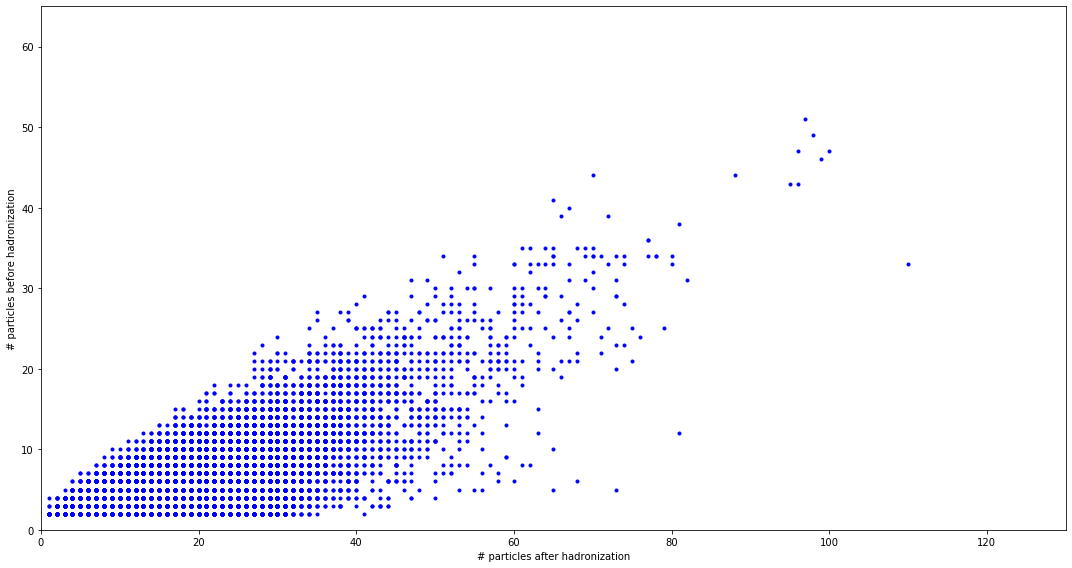

In [40]:
inlen = [ len(c.inparts) for c in AllData ]
outlen = [ len(c.outparts) for c in AllData ]
plt.figure(figsize=(15,8))
plt.plot( outlen, inlen, "b.")
plt.ylabel("# particles before hadronization")
plt.xlabel("# particles after hadronization")
plt.axis([0, 130, 0, 65])
save_fig("scatter_before_after_had")
plt.show()

In [ ]:
eventnum=2
xs, ys = make_datapoints(LargeDat[eventnum].inparts)
xsf, ysf = make_datapoints(LargeDat[eventnum].outparts)
plt.figure(figsize=(10,6))
plt.plot( xs, ys, "b-")
plt.plot( [xs[0]],[ys[0]], "gd")
plt.plot( [xs[-1]],[ys[-1]], "rd")
plt.plot( xsf, ysf, "yo")
plt.xlabel("pz (GeV)")
plt.ylabel("pT (GeV)")
plt.axis([min(xs)-10, max(xs)+10, 0, max(ys)*1.2])
plt.show()

# Processing Data for NN input

In [41]:
from copy import deepcopy
import time

In [42]:
# If chain termininates, this function will zip through in other direction to assess what the quark composition should be
def determine_next(event,spotin,spotout):
    print("{} {}".format(spotin,spotout))
    ins = event.inparts[spotin:]
    ins.reverse()
    outs = event.outparts[spotout:]
    outs.reverse()
    curid = ins[0].id
    for out in outs:
        curid = curid - out.id
    return curid

In [43]:
def make4vec(h,xib,xi1b,RunDiag = False,RunDiagDeep = False):
    # takes as input hadron h and partons x_i, x_i+1; outputs x'_i, x'_i+1 conserving momenta
    # if have a quark and quark, join as diquark, take  gluon in place of quark (may affect showering)
    LOWTHRESHHOLD = 1e-10
    xi = deepcopy(xib) 
    xi1 = deepcopy(xi1b) 
    if xi.id.idtag() * xi1.id.idtag() == 1:
        if RunDiagDeep:
            print('Z0: h xi xi1 xinew xi1new')
            print(h)
            print(xi)
            print(xi1)
        xi.id = xi.id - xi1.id
        xi1.id = partid(21)
        if RunDiagDeep:
            print(xi)
            print(xi1)
    xitemp = xi - h
    if RunDiagDeep:
        print('Z1: h xi xitemp xi1')
        print(h)
        print(xi)
        print(xitemp)
        print(xi1)
    p = xitemp.FourVec()
    if RunDiagDeep:
        print('Z2: p')
        print(p)
    #if abs(p) >= 0:
    #    if RunDiag:
    #        print('A')
    #    return [xitemp+xi1, 0]
        #return [xitemp, xi1]
    q = xi1.FourVec()
    if RunDiagDeep:
        print('Z3: q')
        print(q)
    netxi = xitemp + xi1
    if RunDiagDeep:
        print('Z4: netxi')
        print(netxi)
    # soften E threshold
    if abs(netxi.FourVec().E) < 0.1 and netxi.id.idtag() == 0:
        if RunDiag:
            print('A: h netxi')
            print(h)
            print(netxi)
        return [0,0]
    #if p.E < 0:
    #    qnew = p+q
    #    xi1p = particle(vec4 = qnew, idval = int(xitemp.id - xi1.id))
    #    if RunDiag:
    #        print('B')
    #        print(xi1p)
    #    return [0,xi1p]
    #print(xitemp.Getm0())
    # p' = (p + c q)
    # c^2 qq + 2 pq c + pp - m0^2 =0
    pp = p*p - (xitemp.Getm0())**2
    qq = q*q
    pq = p*q
    c = 1
    if RunDiagDeep:
        print('Z5: pp pq qq')
        print(pp)
        print(pq)
        print(qq)
    if pp > 0 and p.E > 0: #this exception is for when p alone can emit the particle, prevents an error
        c = 0
    elif abs(qq) < LOWTHRESHHOLD:
        if abs(pq) < LOWTHRESHHOLD:
            c = 0
        else:
            c = -pp / (2*pq)
    else:
        c = ( (pq**2 - pp * qq)**0.5 - pq ) /qq
    if RunDiagDeep:
        print('Z6: c')
    if RunDiag or RunDiagDeep:
        print(c) 
    if c < 0 or c > 1:
        if RunDiag:
            print([c, pp, qq, pq, xitemp.Getm0()**2, netxi.id, abs(netxi.FourVec().E)])
        qnew = p+q
        if RunDiagDeep:
            print('Za7: qnew')
            print(qnew)
        xi1p = particle(vec4 = qnew, idval = int(xitemp.id - xi1.id))
        if RunDiagDeep:
            print('Za8: xi1p')
            print(xi1p)
        if (xi1p.id.idtag() == 0):
            # in a terminal chain, sets id to gluons, and splits energy between the two
            xi1p.id = partid(21)
            if RunDiag:
                print('B: h xi xi1 xi1p/2')
                print(h)
                print(xi)
                print(xi1)
                print(xi1p/2)
            return [xi1p/2,xi1p/2]
        else:
            if RunDiag:
                print('C: h xi xi1 xi1p')
                print(h)
                print(xi)
                print(xi1)
                print(xi1p)
            return [0,xi1p]
    pnew = p + (c * q)
    qnew = (1-c) * q
    if RunDiagDeep:
        print('Z7: pnew qnew')
        print(pnew)
        print(qnew)
    if pnew.E < 0:
        qnew = p+q
        xi1p = particle(vec4 = qnew, idval = int(xitemp.id - xi1.id))
        if RunDiag:
            print('D: [c, pp, qq, pq, m^2, netxi.id, netxi.E] pnew qnew xi1p')
            print([c, pp, qq, pq, xitemp.Getm0()**2, netxi.id, abs(netxi.FourVec().E)])
            print(pnew)
            print(qnew)
            print(xi1p)
        return [0,xi1p]
    xip = particle(vec4 = pnew, idval = int(xitemp.id))
    xi1p = particle(vec4 = qnew, idval = int(xi1.id))
    if RunDiag:
        print('E: h xip xi1p')
        print(h)
        print(xip)
        print(xi1p)
    return [xip,xi1p]

In [44]:
def getCommonParts(L1,L2):
    # finds particles in L! with antiparticle in list2
    newlist = []
    L1A = [True for i in L1]
    L2A = [True for i in L2]
    for i in range(len(L1)):
        for j in range(len(L2)):
            if L1[i] == -L2[j] and L1A[i] and L2A[j]:
                newlist.append(L1[i])
                L1A[i] = False
                L2A[j] = False
    return newlist

def stringTestRun(trialPart,outparts,verbose = False):
    pid = partid(trialPart)
    try:
        for op in outparts:
            if verbose:
                print("parton {} : hadron {}".format(pid,op.id))
            pid = pid - op.id
            if verbose:
                print("        to parton {}".format(pid))
        if abs(pid.id) == abs(trialPart):
            return [trialPart, True]
        else:
            [[pid.id,trialPart],False]
    except:
        return [0, False]
    return [0, False]

def abslist(L):
    Lnew = []
    for i in L:
        Lnew.append(abs(i))
    return Lnew

In [45]:
### patch for qqq events (obsolete)
def qqqpatch(New1,New2,eventDat,inID,outID):  #these are to be modified by this function
    try: 
        sumid = New1.id-New2.id
        sumid - eventDat.outparts[outID].id
    except:
        eventDat.outparts.reverse()
        try: 
            sumid = New1.id-New2.id
            sumid - eventDat.outparts[outID].id
        except:
            eventDat.inparts.reverse()
            New1 = eventDat.inparts[0]
            New2 = eventDat.inparts[inID]
            try: 
                sumid = New1.id-New2.id
                sumid - eventDat.outparts[outID].id
            except:
                eventDat.inparts.reverse()

In [46]:
def fixjunctions(ev,verbose=False):
    # adjusts four momenta, reverses input string
    # ev.inparts[0] is the junction 
    
    # check for stray gluon, if present, discard
    if(ev.inparts[-1].id.id == 21):
        ev.inparts = ev.inparts[:-1]
    in4, out4 = ev.sum4(printtoscreen=verbose)
    base4 = ev.inparts[0].vec4
    theid = ev.inparts[0].id.id
    m = 0.3333
    if theid > 1000:
        pdict = beamremnants.get(theid)
        m = pdict.get('mass',0)
    in4noj = in4 - base4
    new4 = out4 - in4noj
    if(verbose):
        print("j4: {} = {} - {}".format(str(new4),str(out4),str(in4noj)))
    c = 0
    pp = new4*new4 - m*m
    if pp < 0:
        # p = new4, q = in4noj
        qq = in4noj*in4noj
        pq = new4*in4noj
        if abs(qq) < 1e-12:
            if abs(pq) < 1e-12:
                c = 0
            else:
                c = -pp / (2*pq)
        else:
            c = ( (pq**2 - pp * qq)**0.5 - pq ) / qq 
        if(verbose):
            print(" c = {}: j4^2 = {}, k^2 = {}, j*k = {}".format(str(c),str(pp),str(qq),str(pq)))
    shifted4 = new4 + c*in4noj
    if(verbose):
        print(" Momentum changed from {} to {}".format(str(base4),str(shifted4)))
        print(" m^2 from {} to {}".format(str(pp+m*m),str(shifted4*shifted4)))
    ev.inparts[0].vec4 = shifted4
    for part in ev.inparts[1:]:
        part.vec4 = part.vec4*(1-c) 
    ev.inparts.reverse()

In [47]:
### patch for gg events (imperfect)
def ggpatch(New1,New2,eventDat):  #these are to be modified by this function
    # first get the first non-trivial particles in the chain
    curoutID = 0
    curID = eventDat.outparts[curoutID].id
    while(len(np.unique(curID.idsplit()))==1 and abs(curID.idtag())==3 and curoutID < len(eventDat.outparts)-1):
        curoutID +=1
        curID = eventDat.outparts[curoutID].id
    outSid = eventDat.outparts[curoutID].id
    curoutID2 = len(eventDat.outparts)-1
    curID = eventDat.outparts[curoutID2].id
    while(len(np.unique(curID.idsplit()))==1 and abs(curID.idtag())==3 and curoutID2 > curoutID):
        curoutID2 -=1
        curID = eventDat.outparts[curoutID2].id
    outEid = eventDat.outparts[curoutID2].id
    if len(np.unique(outEid.idsplit()))==1 and abs(outEid.idtag())==3:
        # there are no meaningful flavor chains, set ends to down quarks
        New1.id = partid(1)
        eventDat.inparts[len(eventDat.inparts)-1].id = partid(-1)
    else:
        #with these particles guess what ends are needed
        newIDvals = getCommonParts(outSid.idprocess(),outEid.idprocess())
        print(newIDvals)
        if newIDvals != []:  # if not, we gamble with gluons
            goodID = 0
            for xid in newIDvals:
                [tempID, validSol] = stringTestRun(xid,eventDat.outparts)
                print("Meson case: [" + str(tempID) +","+str(validSol)+"] ("+str(xid)+")")
                if validSol:
                    goodID = tempID
            if goodID != 0:
                New1.id = partid(goodID)
                print("Using good ID: "+str(goodID))
                eventDat.inparts[len(eventDat.inparts)-1].id = partid(-goodID)
            elif len(newIDvals) > 1: ###baryon exceptional case
                print("In baryon exceptional case")
                if newIDvals[0] * newIDvals[1] > 1:
                    print("Passed test")
                    signtag = int(newIDvals[0]/abs(newIDvals[0]))
                    newIDvals = abslist(newIDvals)
                    newIDvals.sort(reverse = True)
                    goodID = 0
                    if len(newIDvals) == 2:
                        print("In ID 2")
                        xID = signtag*(newIDvals[0]*1000+newIDvals[1]*100+3)
                        [tempID, validSol] = stringTestRun(xID,eventDat.outparts)
                        print("Baryon case 2: [" + str(tempID) +","+str(validSol)+"]")
                        if validSol:
                            goodID = tempID
                        if goodID != 0:
                            New1.id = partid(goodID)
                            eventDat.inparts[len(eventDat.inparts)-1].id = partid(-goodID)
                    elif len(newIDvals) == 3:
                        print("In ID 3")
                        print(newIDvals)
                        for lids in [ [0,1],[0,2],[1,2] ]:
                            print("In ID 3 : sign = "+str(signtag))
                            xID = signtag*(newIDvals[lids[0]]*1000+newIDvals[lids[1]]*100+3)
                            [tempID, validSol] = stringTestRun(xID,eventDat.outparts)
                            print("Baryon case 3: [" + str(tempID) +","+str(validSol)+"]")
                            if validSol:
                                goodID = tempID
                        if goodID != 0:
                            New1.id = partid(goodID)
                            eventDat.inparts[len(eventDat.inparts)-1].id = partid(-goodID)
            else:
                # here we just try additional combinations until something sticks
                print("No good ID found for quarks, trying diquarks")
                baseID = abs(newIDvals[0])
                diquarksign = int(newIDvals[0]/baseID)
                for yID in [1,2,3]:
                    if baseID > yID:
                        newIDvals = [ baseID , yID ]
                    else:
                        newIDvals = [ yID, baseID ]
                    xID = diquarksign*(newIDvals[0]*1000+newIDvals[1]*100+3)
                    print(xID)
                    [tempID, validSol] = stringTestRun(xID,eventDat.outparts)
                    print("Diquark case: [" + str(tempID) +","+str(validSol)+"] ("+str(xID)+")")
                    if validSol:
                        goodID = tempID
                    if goodID != 0:
                        New1.id = partid(goodID)
                        print("Using good ID: "+str(goodID))
                        eventDat.inparts[len(eventDat.inparts)-1].id = partid(-goodID)
                        return

In [48]:
def ConvertEvent(eventDatRaw,reverse=False):
    eventDat = deepcopy(eventDatRaw)
    if reverse:
        eventDat.inparts.reverse()
        eventDat.outparts.reverse()
    inID = 1
    maxIn = len(eventDat.inparts)
    outID = 0
    RNNTrain = []
    New1 = eventDat.inparts[0]
    if New1.id.id < 0 or New1.id.id > 1000:
        print("former qqq - repairing")
        #time.sleep(1.)
        fixjunctions(eventDat)        
        New1 = eventDat.inparts[0]
    New2 = eventDat.inparts[inID]
    ### patch for qqq events (imperfect)
    if New1.id.idtag() * New2.id.idtag() == 1:
        print("qqq event")
        time.sleep(1.)
        qqqpatch(New1,New2,eventDat,inID,outID)
    ### patch for gg events (imperfect)
    if New1.id.idtag() == 0 and eventDat.inparts[len(eventDat.inparts)-1].id.idtag() == 0:
        ggpatch(New1,New2,eventDat)
    # main routine        
    while outID < len(eventDat.outparts):
        [Newx1,Newx2] = make4vec(eventDat.outparts[outID],New1,New2)
        if Newx2 == 0:
            RNNTrain.append([New1,New2,eventDat.outparts[outID]]) #,0,0])
            outID+=1
            continue
        elif Newx1 == 0 and inID < maxIn-1:
            RNNTrain.append([New1,New2,0])#,0,New1+New2])
            inID+=1
            New1 = New1 + New2
            New2 = eventDat.inparts[inID]
        else:
            RNNTrain.append([New1,New2,eventDat.outparts[outID]]) #,Newx1,Newx2])
            New1 = Newx1
            New2 = Newx2
            outID+=1
    return RNNTrain

In [49]:
#this allows a progress bar to be displayed during evaluation
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [50]:
trainDat = []
skiplist=[]
ExceptionList=[]
for eventnum in range(len(AllData)):
    try:
        px = ConvertEvent(AllData[eventnum])
        trainDat.append(px)
    except:
        try:
            px = ConvertEvent(AllData[eventnum],reverse=True)
            trainDat.append(px)
        except Exception as inst:
            skiplist.append(eventnum)
            ExceptionList.append(inst)
            print("Error on event "+str(eventnum)+":", sys.exc_info()[0])
    update_progress(eventnum / len(AllData))

Progress: [##################################################] 100.0%


# Prep for NN 
### the network is in another notebook

In [67]:
# step 1 convert to a readable format
#Xtrain = np.stack([ read_image(FishDIR+i) * np.float32(2. / 255.) - 1  for i in FishFiles ])
#Xtrain[1].dtype

# this is for 1 emission
def convertToNNformat(emn):
    E1, px1, py1, pz1 = np.float32(emn[0].vec4.components())
    E2, px2, py2, pz2 = np.float32(emn[1].vec4.components())
    id1 = emn[0].id.id
    id2 = emn[1].id.id
    if emn[2] == 0:
        npz = np.float32(0)
        keep, px3, py3, pz3, id3 = np.float32(-1),npz,npz,npz,0
    else:
        E3, px3, py3, pz3 = np.float32(emn[2].vec4.components())
        keep = np.float32(1)
        id3 = emn[2].id.id
    return [E1, px1, py1, pz1, E2, px2, py2, pz2, id1, id2], [keep, px3, py3, pz3, id3]
    
def flattenBASE(l, ltypes=(list, tuple)):
    ltype = type(l)
    l = list(l)
    i = 0
    while i < len(l):
        while isinstance(l[i], ltypes):
            if not l[i]:
                l.pop(i)
                i -= 1
                break
            else:
                l[i:i + 1] = l[i]
        i += 1
    return ltype(l)

# much faster than the above
def flattenandadjust(l, ltypes=(list, tuple)):
    ltype = type(l)
    l = list(l)
    i = 0
    while i < len(l):
        while isinstance(l[i][0], ltypes):
            l[i:i + 1] = l[i]
        i += 1
    return ltype(l)

In [68]:
p1 = trainDat
t = time.time()
AllDat = flattenandadjust(p1)
print(time.time()-t)

0.5393128395080566


In [69]:
print(len(AllDat))
print(len(trainDat))

604674
29475


In [70]:
# for the moment, we will ignore any correlations in the data
#Note: appending np arrays is slow, it grows exponentially because of the redefinition, so doing lists, convert latter
def runall(alist):
    x_raw = []
    y_raw = []
    for line in alist:
        x, y = convertToNNformat(line)
        x_raw.append(x)
        y_raw.append(y)
    return x_raw, y_raw

t = time.time()
x_raw, y_raw = runall(AllDat)
print(time.time()-t)

16.014320850372314


In [76]:
t = time.time()
x_raw = np.array(x_raw)
y_raw = np.array(y_raw)
print(time.time()-t)

2.1376030445098877


In [77]:
np.savetxt('x_raw.dat', x_raw)

In [78]:
np.savetxt('y_raw.dat', y_raw)